# Extraction of WCONHIST data from Eclipse data deck

## Import libraries

`ecl_tokenizer` can be found at https://github.com/crayxt/ecl_tokenizer

In [1]:
import sys
sys.path.append("..")
import ecl_tokenizer as et

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

## Load example case from opm-tests repository
Sample Eclipse cases were downloaded from https://github.com/OPM/opm-tests

In [2]:
case = et.EclCase(r"C:\GitHub\opm-tests\norne\NORNE_ATW2013.DATA")

INFO: EclCase init from data deck: C:\GitHub\opm-tests\norne\NORNE_ATW2013.DATA


## Traverse the case and collect dates and values.

Every WCONHIST keyword should be preceeded by either DATES or START keywords.

In [21]:
out_dates  = []
out_values = []
current_date = None

for kwd in case.keywords:
    if kwd.name in ("DATES", "START"):
        #print("Date found")
        current_date = kwd.to_list()
    elif kwd.name == "WCONHIST":
        if not current_date:
            # WCONHIST should always have date set
            raise ValueError("WCONHIST found without preceeding DATES keyword!")
        # Do not expand N*M type of records
        wcon = kwd.to_list(expand=False)
        # populate values
        out_values.extend(wcon)
        # copy the date values as much times as the length of WCONHIST record.
        out_dates.extend(current_date*len(wcon))

print("Dates", len(out_dates), " Values", len(out_values))
assert(len(out_dates ) == len(out_values))

Dates 2109  Values 2109


## Convert the dates
We drop the time part. Could be not the most effective conversion method.

In [4]:
df_dates = pd.DataFrame(out_dates)
print(df_dates.head())
print("Converting...")
df_dates = pd.to_datetime(df_dates[0]+df_dates[1]+df_dates[2], format="%d'%b'%Y")
print(df_dates.head())
df_dates.shape

    0      1     2             3
0  06  'NOV'  1997          None
1  06  'NOV'  1997          None
2  06  'NOV'  1997          None
3  14  'NOV'  1997  00:00:00.001
4   1  'DEC'  1997          None
Converting...
0   1997-11-06
1   1997-11-06
2   1997-11-06
3   1997-11-14
4   1997-12-01
dtype: datetime64[ns]


(2109,)

## Construct the DataFrame
Name the columns per Software manual. Use Dates dataframe as reference.

In [5]:
cols = ["Welname", "Status", "Target", "Orat", "Wrat", "Grat", "Rest"]
w_df = pd.DataFrame(out_values, dtype="float32", index=df_dates, columns=cols)
w_df.index.name = "Date"
w_df = w_df.reset_index()
w_df

,Date,Welname,Status,Target,Orat,Wrat,Grat,Rest
0,1997-11-06,'C-4H','OPEN','ORAT',0.000000,0.000000,0.000000,5*
1,1997-11-06,'B-2H','OPEN','ORAT',0.000000,0.000000,0.000000,5*
2,1997-11-06,'D-1H','OPEN','RESV',4347.700195,0.000000,482594.687500,5*
3,1997-11-14,'D-1H','OPEN','RESV',5601.953125,0.000000,634722.750000,5*
4,1997-12-01,'B-2H','OPEN','RESV',2079.506104,0.000000,230825.031250,5*
...,...,...,...,...,...,...,...,...
2104,2006-11-17,'K-3H','OPEN','RESV',1701.586060,133.300003,542707.625000,5*
2105,2006-11-17,'D-2H','OPEN','RESV',1742.506958,1542.678955,351398.156250,5*
2106,2006-11-17,'E-1H','OPEN','RESV',924.286011,5588.436035,160625.984375,5*
2107,2006-11-17,'E-3CH','OPEN','RESV',150.386002,898.593018,24240.421875,5*


## Plot ORAT chart of 1 well

<AxesSubplot:xlabel='Date'>

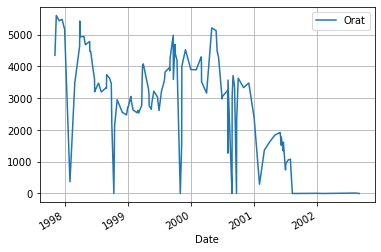

In [16]:
w_df[w_df.Welname == "'D-1H'"].plot(x="Date", y="Orat", grid=True)

## Convert the ORAT values into original table
This is the table thas was used to generate Eclipse Schedule. Or not.

In [10]:
w_df[["Date", "Welname", "Orat"]].pivot(index="Date", columns="Welname")

Orat                                                          \
Welname    'B-1AH'      'B-1BH' 'B-1H'       'B-2H' 'B-3H' 'B-4AH' 'B-4BH'   
Date                                                                         
1997-11-06     NaN          NaN    NaN     0.000000    NaN     NaN     NaN   
1997-11-14     NaN          NaN    NaN          NaN    NaN     NaN     NaN   
1997-12-01     NaN          NaN    NaN  2079.506104    NaN     NaN     NaN   
1997-12-17     NaN          NaN    NaN  5359.973145    NaN     NaN     NaN   
1998-01-01     NaN          NaN    NaN  5194.689941    NaN     NaN     NaN   
...            ...          ...    ...          ...    ...     ...     ...   
2006-10-15     NaN  3415.275879    NaN   884.187988    NaN     NaN     NaN   
2006-11-01     NaN  1641.988037    NaN  1034.286987    NaN     NaN     NaN   
2006-11-09     NaN  1767.900024    NaN   944.849976    NaN     NaN     NaN   
2006-11-11     NaN  1755.250000    NaN   941.317017    NaN     NaN     NaN   
2006-11-17     NaN  1484.500000    NaN   738.828979  8.579     NaN     NaN   

                                      ...                                     \
Welname        'B-4DH' 'B-4H' 'C-1H'  ... 'E-3BH'     'E-3CH' 'E-3H' 'E-4AH'   
Date                                  ...                                      
1997-11-06         NaN    NaN    NaN  ...     NaN         NaN    NaN     NaN   
1997-11-14         NaN    NaN    NaN  ...     NaN         NaN    NaN     NaN   
1997-12-01         NaN    NaN    NaN  ...     NaN         NaN    NaN     NaN   
1997-12-17         NaN    NaN    NaN  ...     NaN         NaN    NaN     NaN   
1998-01-01         NaN    NaN    NaN  ...     NaN         NaN    NaN     NaN   
...                ...    ...    ...  ...     ...         ...    ...     ...   
2006-10-15  188.688004    NaN    NaN  ...     NaN  150.628998    NaN     NaN   
2006-11-01   43.400002    NaN    NaN  ...     NaN  206.013000    NaN     NaN   
2006-11-09   37.700001    NaN    NaN  ...     NaN    0.000000    NaN     NaN   
2006-11-11   58.167000    NaN    NaN  ...     NaN         NaN    NaN     NaN   
2006-11-17   44.070999    NaN    NaN  ...     NaN  150.386002    NaN     NaN   

                                                            
Welname    'E-4H' 'F-1H' 'F-2H' 'F-3H' 'F-4H'       'K-3H'  
Date                                                        
1997-11-06    NaN    NaN    NaN    NaN    NaN          NaN  
1997-11-14    NaN    NaN    NaN    NaN    NaN          NaN  
1997-12-01    NaN    NaN    NaN    NaN    NaN          NaN  
1997-12-17    NaN    NaN    NaN    NaN    NaN          NaN  
1998-01-01    NaN    NaN    NaN    NaN    NaN          NaN  
...           ...    ...    ...    ...    ...          ...  
2006-10-15    NaN    NaN    NaN    NaN    NaN   780.117981  
2006-11-01    NaN    NaN    NaN    NaN    NaN  1816.449951  
2006-11-09    NaN    NaN    NaN    NaN    NaN  1890.050049  
2006-11-11    NaN    NaN    NaN    NaN    NaN  2010.883057  
2006-11-17    NaN    NaN    NaN    NaN    NaN  1701.586060  

[247 rows x 35 columns]